Import Libraries 

In [13]:
import pandas as pd
import numpy as np
import csv
# import warnings
# warnings.filterwarnings('always')
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

Read Data and check dimensions 

In [2]:
df = pd.read_csv('Twitter_Data.csv', header = 0, encoding='utf-8', on_bad_lines='skip')
print('Data Dimension: {}'.format(df.shape))
print('Columns: {}'.format(df.columns))
print('Data Preview {}'.format(df.head))

Data Dimension: (162980, 2)
Columns: Index(['clean_text', 'category'], dtype='object')
Data Preview <bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...      -1.0
1       talk all the nonsense and continue all the dra...       0.0
2       what did just say vote for modi  welcome bjp t...       1.0
3       asking his supporters prefix chowkidar their n...       1.0
4       answer who among these the most powerful world...       1.0
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...      -1.0
162976  dear rss terrorist payal gawar what about modi...      -1.0
162977  did you cover her interaction forum where she ...       0.0
162978  there big project came into india modi dream p...       0.0
162979  have you ever listen about like gurukul where ...       1.0

[162980 rows x 2 columns]>


Check class distribution 

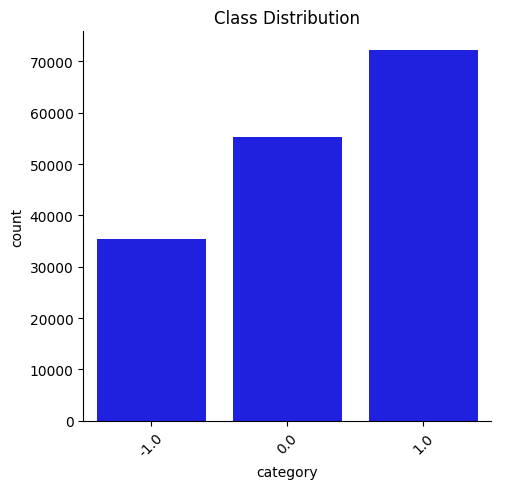

In [3]:
sns.catplot(x="category", data=df, aspect=1, kind="count", color="b")
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

Reduce the sample size to 3000 

In [4]:
# Checking number of samples in each class classes
class_counts = df['category'].value_counts()
print("Class distribution:\n{}".format(class_counts))

# Determine number of classes
num_classes = class_counts.shape[0]
print('number of classes : {}'.format(num_classes))

# Calculate how many samples per class you want
samples_per_class = 3000 // num_classes

# Sample the data
twitter_df = (
    df.groupby('category')
      .apply(lambda x: x.drop(columns='category').sample(n=samples_per_class, random_state=42))
      .reset_index(level=0)
)

print("Balanced sample class distribution:\n", twitter_df['category'].value_counts())

Class distribution:
category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64
number of classes : 3
Balanced sample class distribution:
 category
-1.0    1000
 0.0    1000
 1.0    1000
Name: count, dtype: int64


C:\Users\bhuje\AppData\Local\Temp\ipykernel_26908\1996204121.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop(columns='category').sample(n=samples_per_class, random_state=42))


Data Cleaning and Preprocessing

In [ ]:
def preprocess(text):
    if not isinstance(text, str):
        text = str(text) 
    text = re.sub(r"http\S+|@\S+|#\S+", "", text)        # Remove links, mentions, hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)              # Remove punctuation and numbers
    text = text.lower()                                  # Convert to lowercase
    tokens = text.split()                                # Tokenize
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]  # Remove stopwords
    return " ".join(tokens)

twitter_df['clean_txet'] = twitter_df['clean_text'].apply(preprocess)


Feature Extraction using CountVectorizer

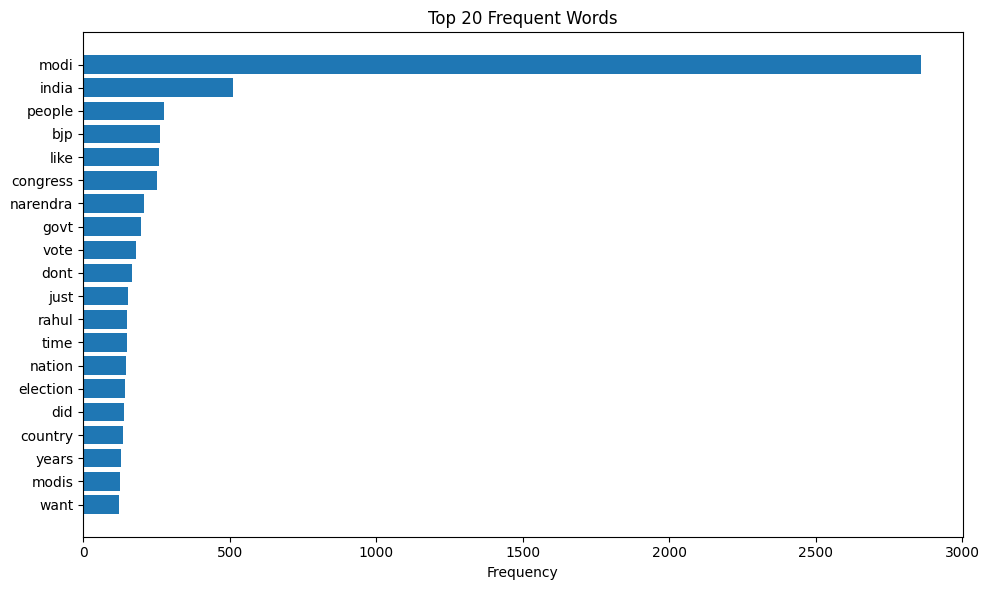

In [14]:
# Assuming this is your CountVectorizer step
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(twitter_df['clean_txet'])

# ✅ Visualize Top 20 Frequent Words
word_counts = np.array(X.sum(axis=0)).flatten()
vocab = vectorizer.get_feature_names_out()
word_freq = dict(zip(vocab, word_counts))

# Sort and select top 20
top_words = Counter(word_freq).most_common(20)

# Plot
plt.figure(figsize=(10, 6))
words, freqs = zip(*top_words)
plt.barh(words[::-1], freqs[::-1])
plt.title("Top 20 Frequent Words")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


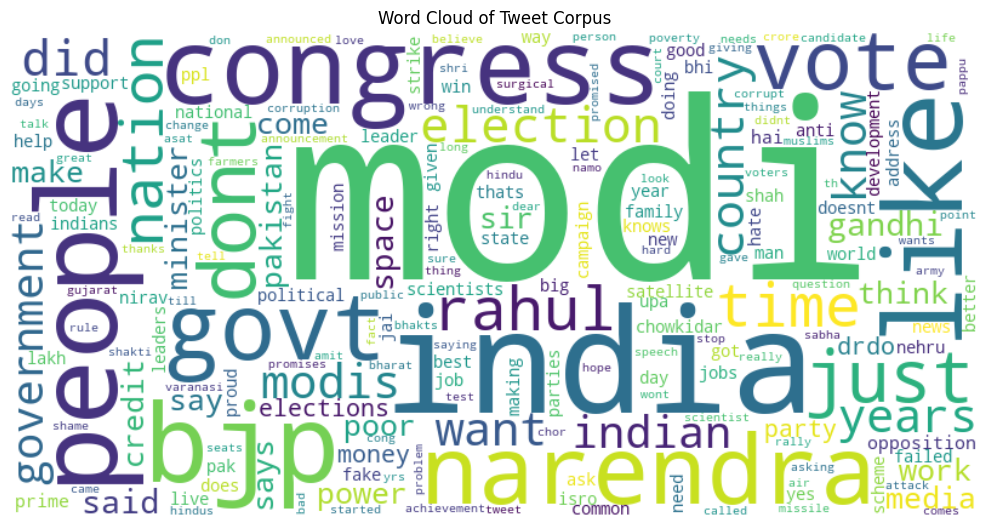

In [15]:
# Word Cloud for the entire vocabulary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweet Corpus")
plt.tight_layout()
plt.show()

Topic Modeling using LDA

In [30]:
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_topic_model = lda_model.fit_transform(X)

Top words for Topic 0: ['hate', 'govt', 'like', 'opposition', 'time', 'people', 'vote', 'bjp', 'congress', 'modi']
Top words for Topic 1: ['drdo', 'government', 'minister', 'credit', 'space', 'nation', 'indian', 'narendra', 'india', 'modi']
Top words for Topic 2: ['want', 'govt', 'gandhi', 'bjp', 'dont', 'rahul', 'people', 'india', 'like', 'modi']


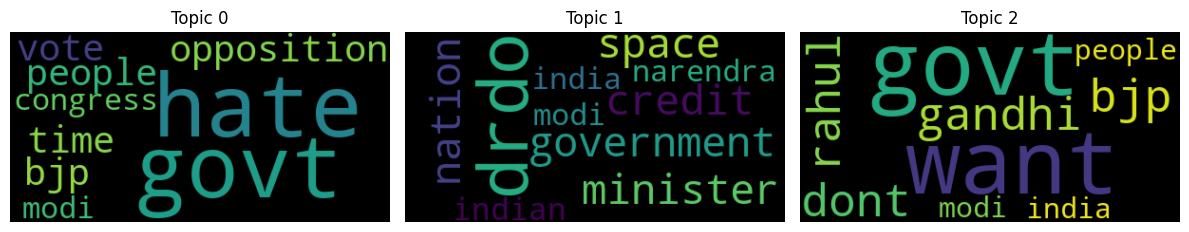

In [47]:
# Get top words for each topic
topic_words = {}
for idx, topic in enumerate(lda_model.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    topic_words[f"Topic {idx}"] = top_words
    print(f"Top words for Topic {idx}: {top_words}")

plt.figure(figsize=(12, 6))
for i, (title, words) in enumerate(topic_words.items()):
    wc = WordCloud(width=400, height=200).generate(' '.join(words))
    plt.subplot(1, 3, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
plt.tight_layout()
plt.show()

In [40]:
lda_topic_model[0]

array([0.67150889, 0.06266733, 0.26582378])

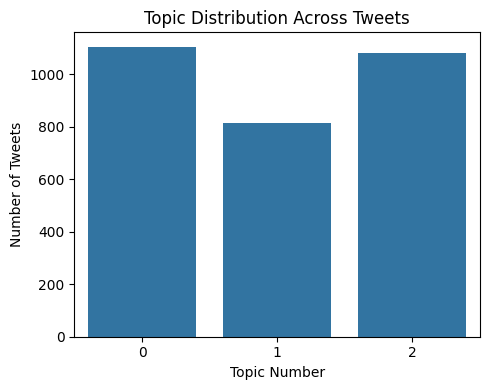

In [50]:
# Count of tweets per topic
twitter_df['dominant_topic'] = np.argmax(lda_topic_model, axis=1)
topic_counts = twitter_df['dominant_topic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(5, 4))
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.xlabel("Topic Number")
plt.ylabel("Number of Tweets")
plt.title("Topic Distribution Across Tweets")
plt.tight_layout()
plt.show()


Assign Sentiment Labels (Using Topics)

In [41]:
topic_labels = np.argmax(lda_topic_model, axis=1)
twitter_df['sentiment'] = topic_labels

Train/Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, topic_labels, test_size=0.2, random_state=42)

Train model using Logistic Regression 

In [43]:
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

Evaluate Model 

In [ ]:
y_pred = lr_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       221
           1       0.87      0.87      0.87       149
           2       0.92      0.87      0.89       230

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600

Confusion Matrix:
 [[200  11  10]
 [ 13 129   7]
 [ 23   8 199]]


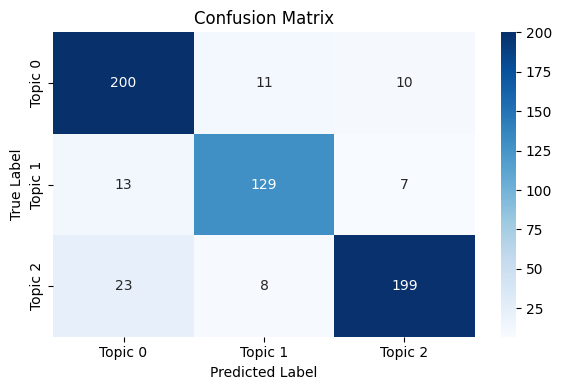

In [48]:
# 📊 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Topic 0', 'Topic 1', 'Topic 2'],
            yticklabels=['Topic 0', 'Topic 1', 'Topic 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

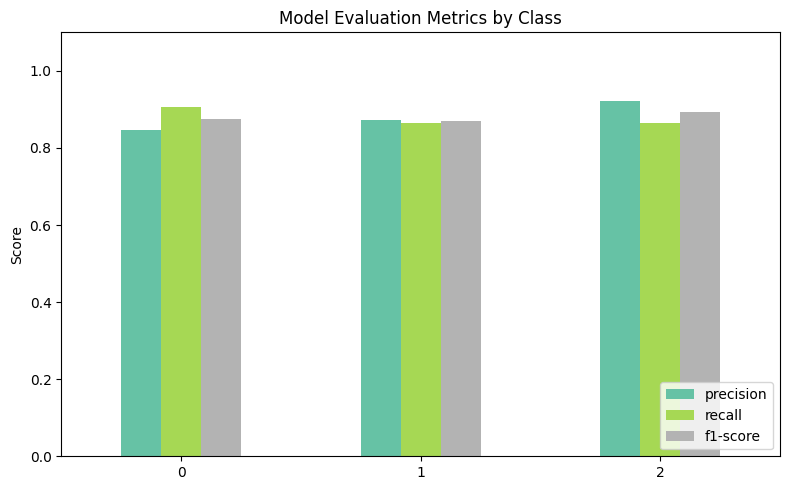

In [49]:
# 📈 2. Precision, Recall, F1-score per topic
classification_rep = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(classification_rep).transpose()
metrics_df = metrics_df.iloc[:3][['precision', 'recall', 'f1-score']]  # Only topics

metrics_df.plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title('Model Evaluation Metrics by Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()